# New dataset

In [1]:
import netCDF4
import numpy as np
import os
import pandas as pd

from tensorflow.keras import layers, Model
import tensorflow as tf

from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging as dtw_avg
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline  

2023-11-23 19:32:11.411852: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 19:32:11.459054: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 19:32:11.460036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 19:32:12.206907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
f = netCDF4.Dataset('./ccm_dataset/radiation/2011_radiation.nc')
#f = netCDF4.Dataset('./ccm_dataset/soil_moisture/2011_soil_moisture.nc')
a = f.variables['Rg']
#a = f.variables['soil_moisture']

In [11]:
df = np.empty((a.shape[1]*a.shape[2], a.shape[0]))

k = 0

for i in range(a.shape[1]):
    for j in range(a.shape[2]):
        df[k,:] = np.array(a[:, i, j])
        k += 1 

In [ ]:
df = pd.DataFrame(df.reshape((a.shape[0], a.shape[1]*a.shape[2])))

In [7]:
not_null_mask = df.notnull().all()

null_counts = df.isnull().sum()

# print the null counts
np.max(null_counts)

0

Text(0.5, 1.0, 'soil moisture 2011')

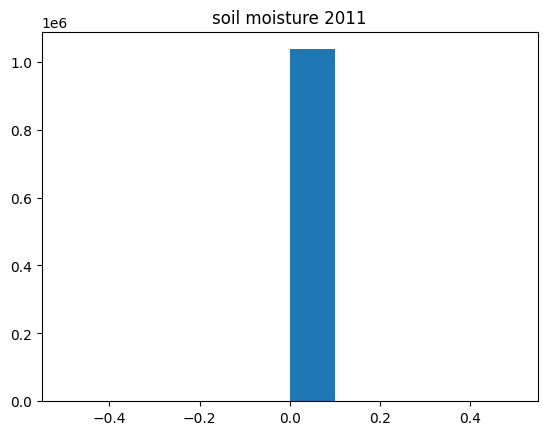

In [9]:
plt.hist(null_counts, bins = 10)
plt.title('soil moisture 2011')

In [4]:
df = np.empty((a.shape[1]*a.shape[2], a.shape[0], 6))

pixels = []
k = 0
lat = f.variables['lat']
lon = f.variables['lon']

for i in range(a.shape[1]):
    for j in range(a.shape[2]):
        df[k,:,3] = np.array(a[:, i, j])
        pixels.append([lat[i], lon[j]])
        k += 1 


In [13]:
#variables = ['air_temperature_2m', 'gross_primary_productivity', 'latent_energy', 'precipitation', 'surface_moisture']
variables = ['air_temperature_2m', 'precipitation', 'soil_moisture']
l = 0

for var in variables:
    f = netCDF4.Dataset(os.path.join('./ccm_dataset/', var, '2011_' + var + '.nc'))
    a = f.variables[var]
    k = 0

    for i in range(a.shape[1]):
        for j in range(a.shape[2]):
            df[k,:,l] = np.array(a[:, i, j])
            k += 1  

    l += 1

variables.append('radiation')

We choose a small set to pre-train the model

In [14]:
ind = np.random.permutation(df.shape[0])
df2 = df[ind[:1000], :, :]

In [15]:
ind = np.random.permutation(df2.shape[0])
training_idx, test_idx = ind[:800], ind[800:]
x_train, x_test = df2[training_idx,:,:], df2[test_idx,:,:]

In [23]:
int(df.shape[0]*0.001)

1036

In [16]:
inp = layers.Input(shape=(df.shape[1], df.shape[2]))
    

encoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(inp)
encoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(encoder)
latent = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(encoder)
decoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(latent)
decoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(decoder)
out = layers.TimeDistributed(layers.Dense(6))(decoder)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46, 6)]           0         
                                                                 
 time_distributed (TimeDistr  (None, 46, 50)           350       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 46, 10)           510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 46, 1)            11        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 46, 10)           20        
 tributed)                                                   

2023-04-07 13:53:31.592587: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
history = autoencoder.fit(x_train, x_train, epochs = 10000, validation_data= (x_test, x_test))

Epoch 1/10000
25/25 [==============================] - 0s 7ms/step - loss: 807867.2500 - val_loss: 935757.6875
Epoch 2/10000
25/25 [==============================] - 0s 6ms/step - loss: 807657.2500 - val_loss: 935509.9375
Epoch 3/10000
25/25 [==============================] - 0s 6ms/step - loss: 807444.0000 - val_loss: 935261.2500
Epoch 4/10000
25/25 [==============================] - 0s 6ms/step - loss: 807231.4375 - val_loss: 935008.9375
Epoch 5/10000
25/25 [==============================] - 0s 6ms/step - loss: 807017.3750 - val_loss: 934773.2500
Epoch 6/10000
25/25 [==============================] - 0s 5ms/step - loss: 806807.1875 - val_loss: 934511.1250
Epoch 7/10000
25/25 [==============================] - 0s 6ms/step - loss: 806592.5000 - val_loss: 934263.0625
Epoch 8/10000
25/25 [==============================] - 0s 6ms/step - loss: 806378.8125 - val_loss: 934020.7500
Epoch 9/10000
25/25 [==============================] - 0s 6ms/step - loss: 806166.0625 - val_loss: 933775.5000
E

In [24]:
encoder = Model(inputs=inp, outputs=latent)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46, 6)]           0         
                                                                 
 time_distributed (TimeDistr  (None, 46, 50)           350       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 46, 10)           510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 46, 1)            11        
 tributed)                                                       
                                                                 
Total params: 871
Trainable params: 871
Non-trainable params: 0
_____________________________________________________________

In [28]:
data = encoder.predict(df2)
data = data.reshape((1000, a.shape[0]))

data = pd.DataFrame(data)

model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=1000)
model.fit(data)

32/32 [==============================] - 0s 2ms/step


TimeSeriesKMeans(max_iter=1000, metric='dtw', n_clusters=5)

In [29]:
data = encoder.predict(df)
data = data.reshape((a.shape[1]*a.shape[2], a.shape[0]))

results = pd.DataFrame()
results['group'] = model.predict(data)

32400/32400 [==============================] - 56s 2ms/step


/media/2tbraid/ochal/tfm/.conda/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1036800 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


KeyboardInterrupt: 

In [30]:
autoencoder.save('./my_model')
encoder.save('./my_encoder')

2023-04-07 15:33:56.616263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,6]
	 [[{{node inputs}}]]
2023-04-07 15:33:56.622959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,6]
	 [[{{node inputs}}]]
2023-04-07 15:33:56.666273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,50]
	 [[{{node inputs}}]]
2023-04-07 15:3

INFO:tensorflow:Assets written to: ./my_model/assets


INFO:tensorflow:Assets written to: ./my_model/assets


2023-04-07 15:33:58.146105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,6]
	 [[{{node inputs}}]]
2023-04-07 15:33:58.152410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,6]
	 [[{{node inputs}}]]
2023-04-07 15:33:58.195802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,50]
	 [[{{node inputs}}]]
2023-04-07 15:3

INFO:tensorflow:Assets written to: ./my_encoder/assets


INFO:tensorflow:Assets written to: ./my_encoder/assets


In [11]:
coord_x = []
coord_y = []

for i in range(len(pixels)):
    coord_x.append(pixels[i][0])
    coord_y.append(pixels[i][1])

results['coord_x'] = coord_x
results['coord_y'] = coord_y

38
74
89


In [ ]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

for group, color in zip(results['group'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
    plt.scatter(x = results.coord_x[results['group'] == group], y = results.coord_y[results['group'] == group], s = 10, color=color, label=f"Group {group}")

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title('Pixels classification on climate type')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()